# Species Genome Analysis and Group Predictor
#### Using Various techniques in the following code I will analyize the genome of a species from each animal group, Human (mammal), Chicken (Bird), Atlantic Salmon (Fish), Common Lizard (Reptile), Common Frog (Amphibian).
#### Then I will utilize these techniques to determine what animal group a mystery genome would belong to. 

## Importing all Libraries

In [54]:
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
from tqdm import tqdm
from joblib import parallel_backend
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import permutations
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display= 'diagram')
from sklearn.metrics import classification_report,  RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import FeatureUnion
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from ktransform.KMerTransformers import *
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
#pio.renderers.default='browser'
pio.renderers.default='svg'
from yellowbrick.classifier import ClassPredictionError, ClassificationReport,  ROCAUC

#### Testing the Imports which are gotten from https://www.ncbi.nlm.nih.gov/datasets/

In [15]:
for seq_record in SeqIO.parse("Species Genomes/human_cds_from_genomic.fna", "fasta"): #human fasta file
    print(seq_record)
    break

ID: lcl|NC_000001.11_cds_NP_001005484.2_1
Name: lcl|NC_000001.11_cds_NP_001005484.2_1
Description: lcl|NC_000001.11_cds_NP_001005484.2_1 [gene=OR4F5] [db_xref=CCDS:CCDS30547.2,Ensembl:ENSP00000493376.2,GeneID:79501] [protein=olfactory receptor 4F5] [protein_id=NP_001005484.2] [location=join(65565..65573,69037..70008)] [gbkey=CDS]
Number of features: 0
Seq('ATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGAGTGAAACG...TAG')


In [16]:
def parse_from_genome_file(filename, target_name, n=None):
    sequences = []
    gene_names = []
    protein_descriptions = []
    targets = []

    for i, seq_record in enumerate(SeqIO.parse(filename, "fasta")):
        if n is not None and i >= n:
            break

        sequences.append(str(seq_record.seq))
        gene_names.append(seq_record.description.split('[')[1][5:-2])
        protein_descriptions.append(seq_record.description.split('[')[3][8:-2])
        targets.append(target_name)

    data = {
        'seq': sequences,
        'gene': gene_names,
        'protein': protein_descriptions,
        'target': targets
    }

    df = pd.DataFrame(data)
    return df

In [17]:
#dataframes for each species genome file
human_df = parse_from_genome_file("Species Genomes/human_cds_from_genomic.fna", 'human', n=20000)
chicken_df = parse_from_genome_file("Species Genomes/chicken_cds_from_genomic.fna", 'chicken', n=20000)
salmon_df = parse_from_genome_file("Species Genomes/atlantic_salmon_cds_from_genomic.fna", 'atlantic salmon', n=20000)
lizard_df = parse_from_genome_file("Species Genomes/common_lizard_cds_from_genomic.fna", 'common lizard', n=20000)
frog_df = parse_from_genome_file("Species Genomes/common_frog_cds_from_genomic.fna", 'common frog', n=20000)

In [18]:
print("Human Dataframe First 5:")
print(human_df.head())
print("\n Human Protein First Value:")
print(human_df.loc[0,'protein'])

Human Dataframe First 5:
                                                 seq          gene  \
0  ATGAAGAAGGTAACTGCAGAGGCTATTTCCTGGAATGAATCAACGA...         OR4F5   
1  ATGCCTAGACACACACATCCTTACTCTGCGTGCATCCCTGGCCTGG...  LOC112268260   
2  ATGGATGGAGAGAATCACTCAGTGGTATCTGAGTTTTTGTTTCTGG...        OR4F29   
3  ATGCGTAGACACACACATCCTTACTCTGCGCGCATCCCTGGCCTGG...  LOC105378947   
4  ATGGATGGAGAGAATCACTCAGTGGTATCTGAGTTTTTGTTTCTGG...        OR4F16   

                                       protein target  
0                       olfactory receptor 4F5  human  
1         uncharacterized protein LOC112268260  human  
2             olfactory receptor 4F3/4F16/4F29  human  
3      proline-rich extensin-like protein EPR1  human  
4  olfactory receptor 4F3/4F16/4F29 isoform X1  human  

 Human Protein First Value:
olfactory receptor 4F5


### Now I can combine all species into one dataframe for comparison and analysis:

In [19]:
species_compare_df = pd.concat([human_df, chicken_df, salmon_df, lizard_df, frog_df], axis=0)

print(species_compare_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   seq      100000 non-null  object
 1   gene     100000 non-null  object
 2   protein  100000 non-null  object
 3   target   100000 non-null  object
dtypes: object(4)
memory usage: 3.8+ MB
None


##### Now compare the sequence information for each species

In [20]:
species_compare_df['seq_length'] = species_compare_df.seq.apply(lambda x: len(x))
print('DNA Sequence Length Info by Species')
print(species_compare_df.groupby('target').seq_length.describe().T)

DNA Sequence Length Info by Species
target  atlantic salmon       chicken   common frog  common lizard  \
count      20000.000000  20000.000000  20000.000000   20000.000000   
mean        2179.743600   2270.381550   2083.091200    2546.304050   
std         2227.227765   2378.435463   2054.270511    5674.985332   
min          114.000000     96.000000     96.000000      96.000000   
25%          972.000000   1005.000000    942.000000    1011.000000   
50%         1551.000000   1614.000000   1461.000000    1608.000000   
75%         2628.000000   2718.000000   2556.000000    2643.750000   
max        26943.000000  30441.000000  26424.000000  103119.000000   

target          human  
count    20000.000000  
mean      2223.094100  
std       3783.049559  
min         37.000000  
25%        939.000000  
50%       1524.000000  
75%       2604.750000  
max     107976.000000  


##### Each code amount

In [22]:
kmer_transformer = KMerTransformer(k=3, verbose=False)
kmer_matrix = kmer_transformer.fit_transform(species_compare_df)
kmer_matrix = pd.concat([kmer_matrix, species_compare_df.target], axis=1)

In [23]:
print("First 5:") #Testing the Kmer matrix
print(kmer_matrix.head())

First 5:
   AAA  AAC  AAG  AAT  ACA  ACC  ACG  ACT  AGA  AGC  ...  TCT  TGA  TGC  TGG  \
0   10   13   13   16   19   10    4   21   15   11  ...   34   23   13   21   
1    9   20   14    4   30   18   14   13   41   19  ...   25   10   45   44   
2    7    5   12   10   17   10    3   22   15   14  ...   31   14   10   30   
3    8   30   15    4   44   34   13   15   64   30  ...   52    9   84   70   
4    7    5   12   10   17   10    3   22   15   14  ...   31   14   10   30   

   TGT  TTA  TTC  TTG  TTT  target  
0   29   16   29   20   35   human  
1   12    5    7    9    9   human  
2   33   11   33   17   33   human  
3   14    4   10    6    7   human  
4   33   11   33   17   33   human  

[5 rows x 65 columns]


In [24]:
print("\n Last 5")
print(kmer_matrix.tail())


 Last 5
       AAA  AAC  AAG  AAT  ACA  ACC  ACG  ACT  AGA  AGC  ...  TCT  TGA  TGC  \
19995   10    7   18   12   15   18    7   12   13   17  ...   19   18   14   
19996   12    5   16   12    6    4    2   12    9   10  ...   12   12   10   
19997   11    4   16   11    5    4    2   13    8   10  ...   13   12   10   
19998   63   24   61   43   40   17    6   18   58   44  ...   36   42   27   
19999    6    4   26    5   10    7    2    8   18    6  ...    8   16    8   

       TGG  TGT  TTA  TTC  TTG  TTT       target  
19995   21   23    8   22   12   12  common frog  
19996   18   21    7   15   13    7  common frog  
19997   16   20    7   15   12    7  common frog  
19998   31   35   31   14   28   21  common frog  
19999    9    6    3    9    7    0  common frog  

[5 rows x 65 columns]


### Plotting the Correlation Between Trimers

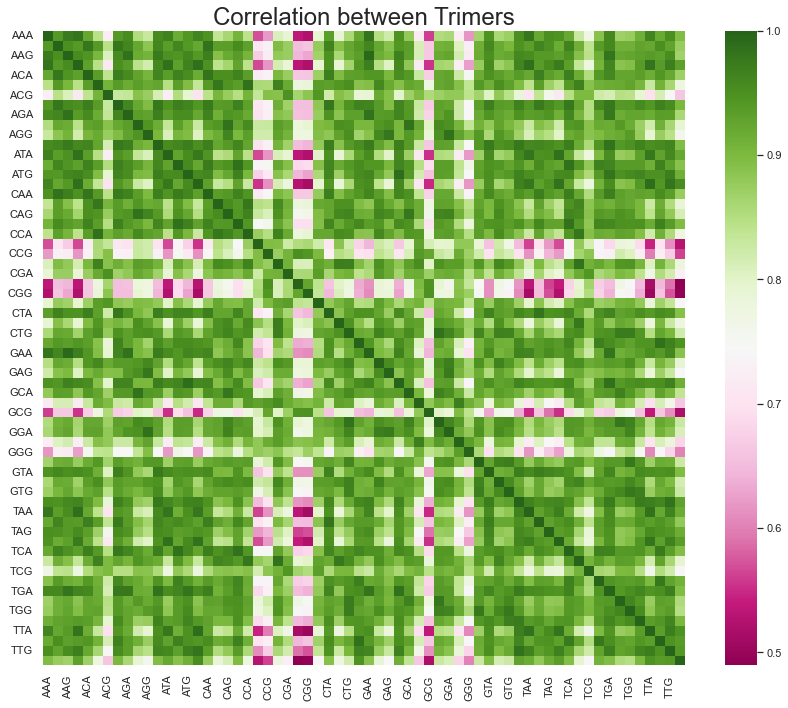

In [33]:
# Calculate the correlation matrix
kmer_corr = kmer_matrix.corr()
# Create a figure with specified size
fig, ax = plt.subplots(figsize=(12, 10))
# Set the title of the heatmap
ax.set_title('Correlation between Trimers', fontsize=24)
# Set the font scale for the heatmap
sns.set(font_scale=1.0)
# Plot the heatmap with the correlation matrix and specified colormap
sns.heatmap(kmer_corr, cmap="PiYG")
# Adjust the layout to fit everything nicely
plt.tight_layout()
# Display the plot
plt.show()

###### So there is a high correlation between a majority of the codons

### **Find the mean for each codon**

In [34]:
mean_agg_df = kmer_matrix.groupby('target', sort=False).agg(['mean'])
print(mean_agg_df)

                      AAA       AAC       AAG       AAT       ACA       ACC  \
                     mean      mean      mean      mean      mean      mean   
target                                                                        
human            60.05045  33.26285  57.96355  34.13340  42.80850  35.06830   
chicken          69.47135  37.87660  62.10415  38.86080  48.77285  30.54200   
atlantic salmon  30.20555  34.59440  44.49225  16.48980  47.99045  44.75290   
common lizard    72.13730  42.35425  70.72875  40.47420  51.81215  38.69295   
common frog      63.86465  36.59890  54.28450  38.67715  49.86050  30.71960   

                      ACG       ACT       AGA       AGC  ...       TCG  \
                     mean      mean      mean      mean  ...      mean   
target                                                   ...             
human            12.71650  31.88435  61.69320  46.19935  ...  11.32470   
chicken          14.05670  34.53575  67.07405  48.58565  ...  10.78970 

In [ ]:
# Set up dimensions for subplots and the final graph
num_rows = 16
num_cols = 4
total_fig_cols = 5
total_fig_rows = 1

# Get the maximum and minimum values for scaling
mean_agg_df = mean_agg_df
global_max = mean_agg_df.max().max()
global_min = mean_agg_df.min().min()

# Extract titles and trimers for each subplot
titles = [f'{x.title()} Genome' for x in mean_agg_df.index]
kmer_labels = np.array([x[0] for x in mean_agg_df.columns]).reshape(num_rows, num_cols)

# Scale the data using MinMax scaling
scaled_data = (mean_agg_df.values - global_min) / (global_max - global_min)

# Initialize the subplot figure
fig = make_subplots(rows=total_fig_rows, cols=total_fig_cols, subplot_titles=titles)
layout_config = {
    'title': 'Scaled Mean Values of Each Trimer Grouped by Genome',
    'width': 1200,
    'height': 600
}

# Plot each subplot
for fig_row in range(total_fig_rows):
    for fig_col in range(total_fig_cols):
        subplot_index = fig_col + total_fig_cols * fig_row
        if subplot_index >= len(scaled_data):
            break

        heatmap_data = scaled_data[subplot_index].reshape(num_rows, num_cols)
        fig.add_trace(
            go.Heatmap(z=heatmap_data, coloraxis='coloraxis'),
            row=fig_row + 1,
            col=fig_col + 1
        )

        # Annotate each cell in the heatmap with trimer labels
        for r in range(num_rows):
            for c in range(num_cols):
                fig.add_annotation(
                    text=kmer_labels[r, c],
                    x=c,
                    y=r,
                    showarrow=False,
                    row=fig_row + 1,
                    col=fig_col + 1,
                    font=dict(size=9, color="#222299")
                )

        layout_config[f'xaxis{subplot_index + 1 if subplot_index > 0 else ""}'] = {'visible': False}
        layout_config[f'yaxis{subplot_index + 1 if subplot_index > 0 else ""}'] = {'autorange': 'reversed', 'visible': False}

fig.update_layout(layout_config)
fig.update_coloraxes(colorscale='sunset')
fig.show()

![image](images/mean_graph.png)

### Further Analysis for STD for each codon

In [42]:
var_agg_df = kmer_matrix.groupby('target', sort=False).agg(['std'])
print(var_agg_df)

                        AAA         AAC         AAG         AAT         ACA  \
                        std         std         std         std         std   
target                                                                        
human            152.153083   67.535213  125.513032   79.050806   82.045860   
chicken           90.495044   43.472231   76.108113   47.533720   55.335129   
atlantic salmon   42.164382   37.211142   53.728422   20.522601   52.202711   
common lizard    221.658962  112.011717  196.121788  112.512916  123.953727   
common frog       77.310447   46.900674   59.589310   44.031860   61.178639   

                       ACC        ACG        ACT         AGA         AGC  ...  \
                       std        std        std         std         std  ...   
target                                                                    ...   
human            65.103286  18.894305  62.431629  122.006125   67.952802  ...   
chicken          32.847194  14.245351  39.3

# Cumulative Accuracy Model for all 5 Species

After several trials I found these hyperparamters to be most ideal:
1. KGroupTransformer: k=24
2. KMerTransformer: k=6
3. ExtraTreesClassifier: n_estimators=300

In [45]:
# Separate features and target
multilabeler = LabelEncoder()
X = species_compare_df.drop(columns='target')
y = multilabeler.fit_transform(species_compare_df['target'])


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Define the pipelines for feature processing
kgroup_pipeline = Pipeline([
    ('kgroup_transformer', KGroupKMerTransformer(k=24, verbose=False)),
    ('kgroup_column_pruner', KGroupColumnPruner(verbose=False))
])

kmer_pipeline = Pipeline([
    ('kmer_transformer', KMerTransformer(k=6, verbose=False))
])

# Combine the feature pipelines
feature_union = FeatureUnion([
    ('p1', kgroup_pipeline),
    ('p2', kmer_pipeline)
])

# Define the final model pipeline
final_model = Pipeline(steps=[
    ('trans_union', feature_union),
    ('scaler', StandardScaler()),
    ('classifier', ExtraTreesClassifier(n_estimators=300, random_state=42))
])

# Fit the model on the training data
final_model.fit(X_train, y_train)

# Make predictions on the test data
y_preds = final_model.predict(X_test)

print(final_model)

Pipeline(steps=[('trans_union',
                 FeatureUnion(transformer_list=[('p1',
                                                 Pipeline(steps=[('kgroup_transformer',
                                                                  KGroupKMerTransformer(k=24,
                                                                                        verbose=False)),
                                                                 ('kgroup_column_pruner',
                                                                  KGroupColumnPruner(verbose=False))])),
                                                ('p2',
                                                 Pipeline(steps=[('kmer_transformer',
                                                                  KMerTransformer(k=6,
                                                                                  verbose=False))]))])),
                ('scaler', StandardScaler()),
                ('classifier',
                 Extr

In [49]:
print(classification_report(multilabeler.inverse_transform(y_test), multilabeler.inverse_transform(y_preds)))

                 precision    recall  f1-score   support

atlantic salmon       0.84      0.96      0.90      5011
        chicken       0.99      0.90      0.94      5036
    common frog       0.79      0.93      0.86      4993
  common lizard       0.94      0.79      0.86      4985
          human       0.99      0.93      0.96      4975

       accuracy                           0.90     25000
      macro avg       0.91      0.90      0.90     25000
   weighted avg       0.91      0.90      0.90     25000



### Graphing and Visualizing all the data

0.90232

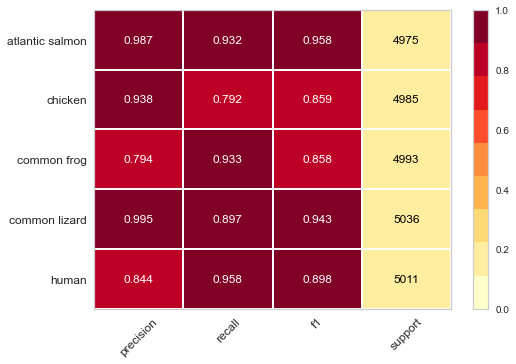

In [51]:
visualizer = ClassificationReport(final_model, classes=multilabeler.classes_, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data

0.90232

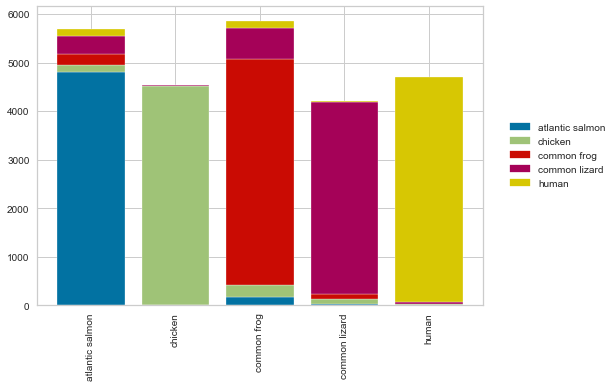

In [58]:
visualizer = ClassPredictionError(final_model, classes=multilabeler.classes_)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

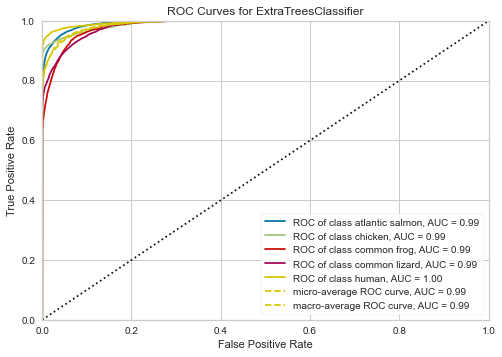

<AxesSubplot:title={'center':'ROC Curves for ExtraTreesClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [61]:
visualizer = ROCAUC(final_model, classes=multilabeler.classes_, support = True)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.set_title("(ROC) Curves")
visualizer.ax.set_xlabel("False Positive Rate")
visualizer.ax.set_ylabel("True Positive Rate")
visualizer.ax.legend(loc='lower right')

# Display the plot
visualizer.show()

##### We were able to achieve a very strong accuracy with the hyperparamters for the species genome analyis


# Using the data analysis to figure out which animal group a new unknown genome belongs to

### Put in two new mystery genomes

In [81]:
mystery_df = parse_from_genome_file("Species Genomes/chimp_cds_from_genomic.fna", 'mystery', n=20000)
mystery2_df = parse_from_genome_file("Species Genomes/golden_eagle_cds_from_genomic.fna", 'mystery2', n=20000)
species_compare_df = pd.concat([human_df, chicken_df, salmon_df, lizard_df, frog_df, mystery_df, mystery2_df], axis=0)
species_compare_df['seq_length'] = species_compare_df.seq.apply(lambda x: len(x))

kmer_transformer = KMerTransformer(k=3, verbose=False)
kmer_matrix = kmer_transformer.fit_transform(species_compare_df)
kmer_matrix = pd.concat([kmer_matrix, species_compare_df.target], axis=1)

mean_agg_df = kmer_matrix.groupby('target', sort=False).agg(['mean'])

#get the total max and min for scaling later
mean_agg = mean_agg_df
mean_max = mean_agg.max().max()
mean_min = mean_agg.min().min()

#Extract the title for each subplot, and the trimers in each matrix
mean_agg_index = [f'{x.title()} Genome' for x in mean_agg.index]
kmer_index = np.array([x[0] for x in mean_agg.columns]).reshape(rows, cols)
#scale the data with MinMax
mean_agg = (np.array(mean_agg) - mean_min) / (mean_max - mean_min)


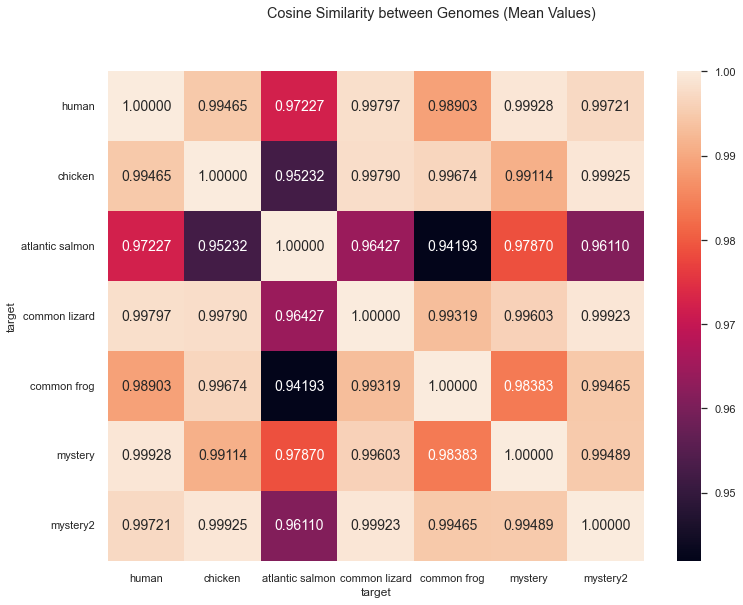

In [82]:
# Calculate the cosine similarity
cosine_similarity_map = pd.DataFrame(
    cosine_similarity(np.array(mean_agg_df), np.array(mean_agg_df)),
    index=mean_agg_df.index,
    columns=mean_agg_df.index
)

# Create the figure and set the plot style
fig = plt.figure(figsize=(12, 9))
sns.set(font_scale=1)
sns.set_style("whitegrid")

# Plot the heatmap with precise annotation values
sns.heatmap(
    cosine_similarity_map,
    annot=True,
    fmt=".5f",  # Format the annotations to 4 decimal places
    annot_kws={"size": 14}  # Adjust the font size of annotations
)

# Add a title to the plot
plt.suptitle('Cosine Similarity between Genomes (Mean Values)')

# Display the plot
plt.show()

### So we find out that the First Mystery Genome has the highest value in the human area so it is most likely a mammal, and then when I check the download I can confirm it is a Chimp's genome and so it is a mammal.

### The second mystery genome has the highest value in the Chicken area so it is most likely a bird, and again when I check the download I confirm it is a golden eagle's genome so it is a bird